# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 0. Dependencies

As this report shares moslty of it's dependencies as the "root" repository, forked from Udacity Deep Reinforcement Learning", the instruction for handling dependencies are the same as the stated at README.md. Please refer to the README at the root of this repository for the original for installing and handling dependencies.

## 1. Start the Environment
The cell below will import all the needed libraries and python modules that are needed. The following cell will load the Udacity Tennis environment which uses Unity in order to place two players in a match. 

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import random
import torch

In [2]:
VIS_ENABLED=False

if VIS_ENABLED:
    env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64", worker_id=random.randint(0,100))
else:
    env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64", worker_id=random.randint(0,100))
        
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Agent setup

### 3.1 Method description 
For this problem i decided to use the same **DDPG agent** for the second project, the Continous Control. Altough there are many methods that could be used, this rapidly converged to desired score. Other approaches will be listed at the **Future improvements** sections below. 

### 3.2 Parameters description

As the same agent was used, this is just a **copy** from the "Continous Control" project, also present in this repository at the "p2_continous-control" folder. 

| Parameter             |Description                                                                                       |
|-----------------------|--------------------------------------------------------------------------------------------------|
| state size            | Size of the state the is observed from the agent                                                 |
| action size           | Size of the state the agent uses to interact with the environment                                |
| random_seed           | Seed used for internally generate random variables                                               |
| buffer_size           | Maximum number of entries for the replay buffer                                                  |
| batch_size            | How many replay buffer entires will be used for each learning                                    |
| gamma                 | Discount factor                                                                                  |
| tau                   | Smooth factor used for uptading the local networks parameters from target network parameters     |
| lr_actor              | Learning rate for the actor Network                                                              |
| lr_critic             | Learning rate for the critic network                                                             |
| actor_weight_decay    | L2 Weight regularizer for the actor netowrk                                                      |
| critic_weight_decay   | L2 Weight regularizer for the critic network                                                     |   
| learn_prescaler       | How many steps the agent should run between each learning                                        |
| learning_cycles       | How many many times the agent should run the backprop. proccess after **learn_prescaler** cycles |
| noise_initial_gain    | The initial gain applied for the noise added to the network output.                              |
| noise_gain_decay      | Factor to multiply **noise_initial_gain** for each step. Makes the noise gain decay as the proccess goes. Keep it 1.0 to disable this behaviour |
| sample_every_cycle    | For each **learning_cycles**, if the agent should sample from the replay buffer. If false, the agent will try to run the backprop **learning_cycles** in a row using the same initial sample.                                    |
| gradient_limiter      | If the agent should, or should not, limit the gradient for gradient ascent step                   |

In [4]:
%load_ext autoreload
%autoreload 2
from ddpg_agent import Agent

agent = Agent(state_size          = state_size, 
              action_size         = action_size, 
              random_seed         = 2, 
              buffer_size         = 100000,
              batch_size          = 128,
              gamma               = 0.99,
              tau                 = 1e-3,
              lr_actor            = 2e-4,
              lr_critic           = 2e-4,
              actor_weight_decay  = 0,
              critic_weight_decay = 0,
              learn_prescaler     = 20, 
              learning_cycles     = 10, 
              noise_initial_gain  = 1.0,
              noise_gain_decay    = 1.0,
              sample_every_cycle  = True, 
              gradient_limiter    = True)

## 4. DDPG Agent network representation

Below we have an description of the Agent and Critic networks that are used by the DDPG agent.

In [47]:
print( agent )

Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 5. Learning proccess

The DDPG method, contained in the following cell, drives the learning of the agent in a slighly different manner than the original usage, at the Continous Control project. 

As the Continous Control we use an multi agent environment but, in this scenario, the agents play one against another. The observation of each agent is added to the replay buffer and the "match" is set reach an duration of maximum **max_t**. 

For each agent the last iteration of the DDPG learning proccess is used in order generate the action in response to the environment state. Different of the multi-agent variation of the Continous Control proccess, where the multiple agents were used in order to generate move diverse samples and speed-up training, in this project, the agent play agains itself, generating the actions in response in order to react. 

Like in the Continous Control project, the learning for each episode is performed using the following steps:

**1.** The environment states are used in order to infer the actions using the local Actor network at the agent. Each output corresponds to one agent action.

**2.** The actions are passed down to the environment in order to update what each agent should perform given it's present state. One important note is the that the "act" function countains a "implicit" parameter, add_noise, that by default add an random value to the network output. This will allow the agent to explore the environment and add new values to the replay buffer that would not be achieve otherwise.

**3.** After updating the simulation the current state, action, next state, rewards and if the agent achieved the desired goal are inserted into the replay buffer. Note that for the multi-agent environment this will be done for each "tuple" for these variables.

**4.** Finally, the agent step method will perform the hard work of adding up this tuple to the replay buffer and at each learn_prescaler samples to perform learning_cycles back propagation cycles to the network. As stated above if sample_every_cycle is True, each backpropagation will update the "target" version of the Actor and Critic networks using batch_size samples from the replay buffer sampled for each cycle.

A difference between the multi agent DDPG used for the continous control project is how the reward is handled. For an multi-agent with "no competition" environment, averaing the reward between all the agents is a sound idea, as it is possible for all agents to achieve a good reward. For a "Zero sum game", like the tennis match, if average was used we would end up with scores with mean around "zero", as if one agent wins, the other will loose. 

In order to avoid this scenario and achieve the performance of the best player, the greater reward of each episode in used in order to evaluate the performance of the agent, as this represent how well the network is playing the game. 

One important parameter for this step is tau, which will smooth out the Target network parameters before applying for the actor and critic network. This proccess is important to make the larning more stable as the most recent result of the gradient ascent will be only contribute to the "local" parameters of the networks

In [5]:
def ddpg(n_episodes=10000, max_t=10000, print_every=100):   
    scores_deque = deque(maxlen=print_every)
    scores = []

    
    for i_episode in range(1, n_episodes+1):
        
        states = env.reset(train_mode=True)[brain_name].vector_observations     # reset the environment    
        agent.reset()
        
        scores_episode = np.zeros(num_agents)               # rewards per episode for each agent
        
        for t in range( max_t ):
            actions     = agent.act(states)
            env_info    = env.step(actions)[brain_name]     # send all actions to tne environment
            next_states = env_info.vector_observations      # get next state (for each agent)
            rewards     = env_info.rewards                  # get reward (for each agent)
            dones       = env_info.local_done               # see if episode finished
            
            for (state, action, reward, next_state, done) in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            
            states = next_states
            scores_episode += rewards
            
            if any(dones):
                break 
                
        
        #Averaring the mean score across all agents for this episode
        ep_score = np.max( scores_episode )

        scores.append( ep_score )
        scores_deque.append( ep_score )
        
        
        print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, np.mean( scores_deque )), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}'.format(i_episode, np.mean( scores_deque )))
            
    return scores

scores = ddpg()

Episode 5	Average Score: 0.00000

/home/bmendonca/workspace/udacity/deep-reinforcement-learning/p3_collab-compet/ddpg_agent.py:171: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100	Average Score: 0.00090
Episode 200	Average Score: 0.00000
Episode 300	Average Score: 0.00000
Episode 400	Average Score: 0.00000
Episode 500	Average Score: 0.00000
Episode 600	Average Score: 0.00000
Episode 700	Average Score: 0.00000
Episode 800	Average Score: 0.00000
Episode 900	Average Score: 0.00000
Episode 1000	Average Score: 0.00000
Episode 1100	Average Score: 0.00000
Episode 1200	Average Score: 0.00190
Episode 1300	Average Score: 0.00000
Episode 1400	Average Score: 0.00000
Episode 1500	Average Score: 0.00100
Episode 1600	Average Score: 0.00000
Episode 1700	Average Score: 0.00780
Episode 1800	Average Score: 0.01730
Episode 1900	Average Score: 0.02370
Episode 2000	Average Score: 0.00790
Episode 2100	Average Score: 0.00100
Episode 2200	Average Score: 0.00100
Episode 2300	Average Score: 0.00000
Episode 2400	Average Score: 0.01560
Episode 2500	Average Score: 0.04590
Episode 2600	Average Score: 0.05430
Episode 2700	Average Score: 0.32930
Episode 2800	Average Score: 0.38990
E

When finished, you can close the environment.

In [6]:
env.close()

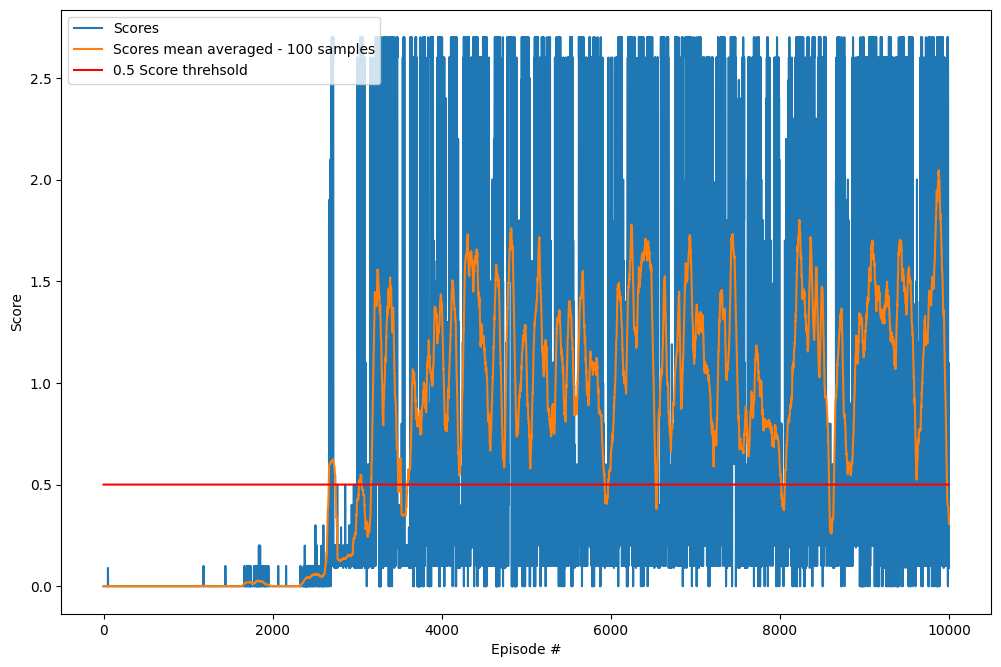

In [45]:
import matplotlib.pyplot as plt

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w


_100_mean_score = moving_average( scores, 100 )
threshold = 0.5*np.ones( len( scores ) )

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.plot( _100_mean_score )
plt.plot( threshold, 'r-' )
plt.legend(['Scores',
            'Scores mean averaged - 100 samples',
            '0.5 Score threhsold'])
plt.show()

## Results

As we can see in the graph above, were the threshold line is plotted, after around 3000 episode we achieved the desired mean score greather than 0.5. Altough i let the agent playing for 10000 episodes, it seems that the later epised did not increased the mean result by much, so it probably would be a nice improvement to implement some sort of "early stop" in order stop the training and to not waste computing time. 

## Future improvements

As some future works, a alternative for this project is:

**1.** Using A2C and A3C
**2.** Use D4PG as a alternative to DDPG.
**3.** Prioritized experience replay. "This was a suggestion made by the reviewer of the last project, Continous Control"
**4.** Altough a simple improvement, it would be nice to add some sort of mechanism that would only save the network checkpoint uppon improvements on the mean score for the last **n** episodes in order to make "sure" that the 